In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mysql.connector
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# MySQL Connection

In [2]:
hostname = "localhost" #Please include host name here for Mysql connection
usr= "root" # Please include root name or other user name
paswd= "12345" # Password
dbname= "kochbar_dataset" # Database name to access data


mydb = mysql.connector.connect(
    host= hostname,
    user=usr,
    password=paswd,
    database=dbname
)
cursor = mydb.cursor()

# Load Data from MySQL to Python
We are selecting four data sets from database out of which two are from festival and two are from non festival. 

**Festival**:

**Christmas** : 2013-12-22 to 2013-12-26.  **Easter**: 2013-03-27 to 2013-04-01 .

**Non Festival**:

**November**:2013-11-26 to 2013-11-30. **February**:2014-02-18 to 2014-02-22.


In [9]:
# we selected 2 festival dates: Easter and Christmas; and 2 non festival dates - one in summer and other in winter

# For each we are considering timespan of 5 days

# data from 2013-03-27 to 2013-04-01
q_easter = "select country_region, city, recipe_id, target_link, SUBSTRING_INDEX(SUBSTRING_INDEX((SUBSTRING_INDEX(target_link, '/', -2)),'/',-1),'.',1)  recipe_name from logs_recipeids_utf8 where country = 'DE' and date between '2013-03-27 00:00:00' and '2013-04-02 00:00:00'"

# data from 2013-12-22 to 2013-12-26
q_christmas="select country_region, city, recipe_id, target_link, SUBSTRING_INDEX(SUBSTRING_INDEX((SUBSTRING_INDEX(target_link, '/', -2)),'/',-1),'.',1)  recipe_name from logs_recipeids_utf8 where country = 'DE' and date between '2013-12-22 00:00:00' and '2013-12-27 00:00:00'"

#data from 2013-11-26 to 2013-11-30
q_november  = "select country_region, city, recipe_id, target_link, SUBSTRING_INDEX(SUBSTRING_INDEX((SUBSTRING_INDEX(target_link, '/', -2)),'/',-1),'.',1)  recipe_name from logs_recipeids_utf8 where country = 'DE' and date between '2013-11-26 00:00:00' and '2013-12-01 00:00:00'"

#data from 2014-02-18 to 2014-02-22
q_february=   "select country_region, city, recipe_id, target_link, SUBSTRING_INDEX(SUBSTRING_INDEX((SUBSTRING_INDEX(target_link, '/', -2)),'/',-1),'.',1)  recipe_name from logs_recipeids_utf8 where country = 'DE' and date between '2014-02-18 00:00:00' and '2014-02-23 00:00:00'"


cols = ['country_region','city','recipe_id','target_link', 'recipe_name']


In [4]:
#extract from database, easter
cursor.execute(q_easter)

myresult = cursor.fetchall()

#put the data into a dataframe
df_e = pd.DataFrame(myresult, columns=cols)

#update recipe name to lower case
df_e['recipe_name'] = df_e['recipe_name'].str.lower()


In [5]:
#extract from database, Christmas
cursor.execute(q_christmas)
myresult = cursor.fetchall()

#put the data into a dataframe
df_c = pd.DataFrame(myresult, columns = cols)

#update recipe name to lower case
df_c['recipe_name'] = df_c['recipe_name'].str.lower()


In [7]:
#extract from database, November days
cursor.execute(q_november)
myresult = cursor.fetchall()

#put the data into a dataframe
df_n = pd.DataFrame(myresult, columns=cols)

#update recipe name to lower case
df_n['recipe_name'] = df_n['recipe_name'].str.lower()


In [12]:
#extract from database, February days
cursor.execute(q_february)
myresult = cursor.fetchall()

#put the data into a dataframe
df_f = pd.DataFrame(myresult, columns = cols)

#update recipe name to lower case
df_f['recipe_name'] = df_f['recipe_name'].str.lower()


# Size of both festival and non festival data sets

In [13]:
df_f.shape
df_n.shape
df_e.shape
df_c.shape

(1286953, 5)

(1494525, 5)

(1986723, 5)

(2491260, 5)

# The DataFrame for plotting the Recipe frequency in Log Scale


In [14]:
# given a dataframe, plots the Recipe frequency in a log scale

def plot_tf_by_df(df, title, w, h, filename):
    

    df_p = df.groupby('recipe_name').count()[['recipe_id']].sort_values(['recipe_id'], ascending=False).copy()
    df_p.reset_index(level=0, inplace=True)
        
    df_p = df_p.drop(columns=['recipe_name'])
    df_p.columns = ['frequency of recipe name']
    df_p.index += 1
    
    ax = df_p.plot( logx=True, figsize=(15,10), title=title, use_index=True, legend=True)
    # Set x and y label in graph
    ax.set_xlabel("Number of distinct recipes (log)")
    ax.set_ylabel("Frequency of recipe")
    ax.figure.savefig(filename, bbox_inches='tight')
    
    return


# Plotting the Log scale 

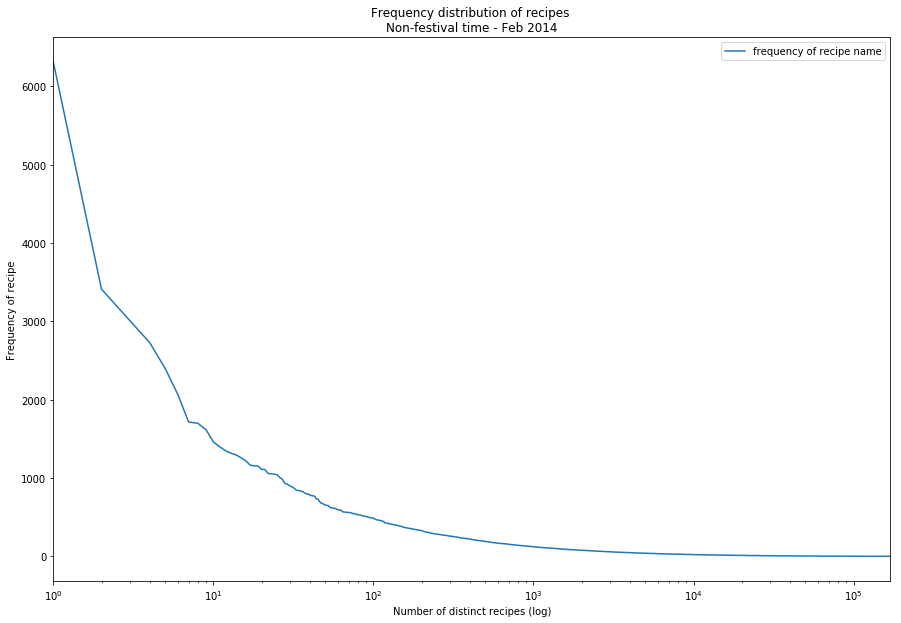

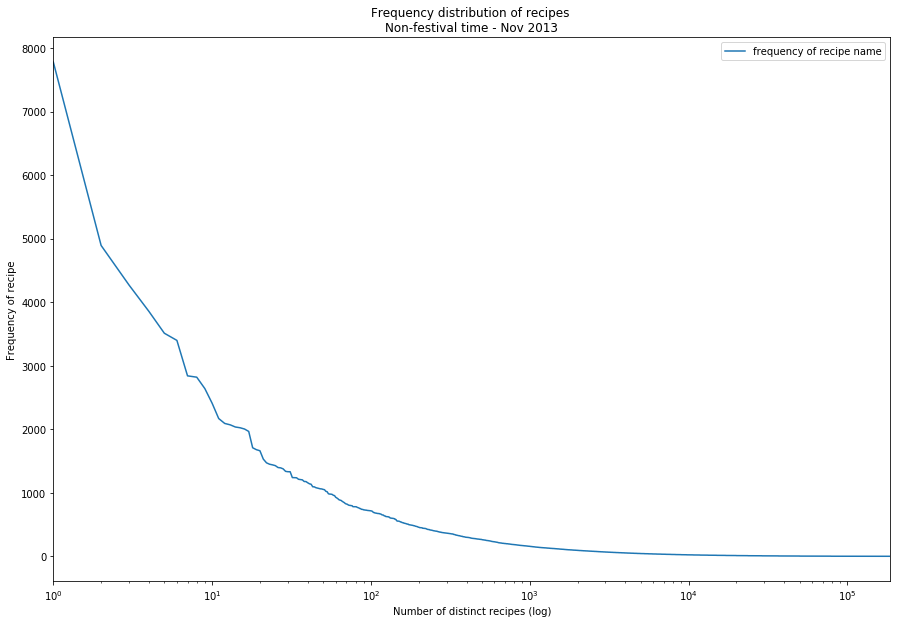

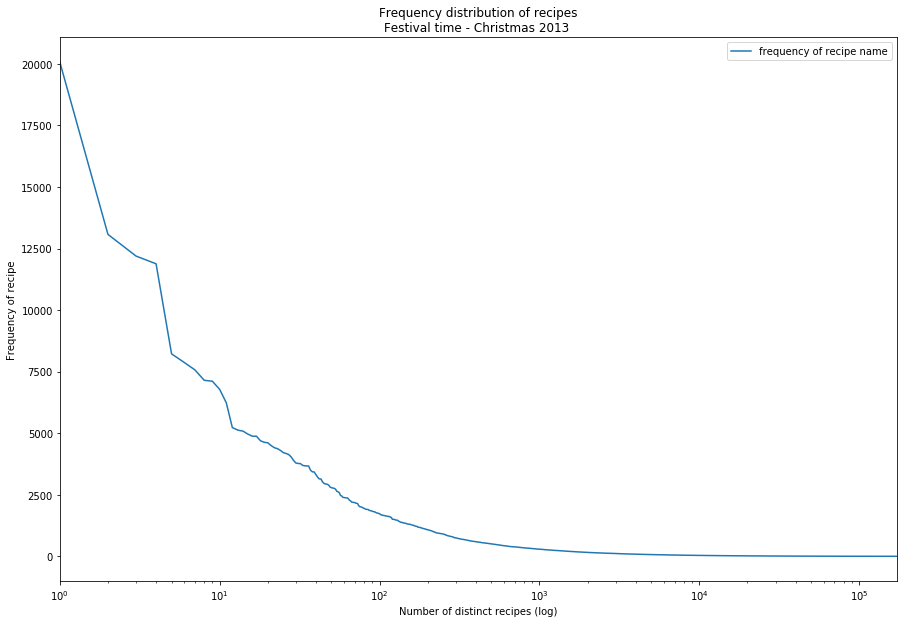

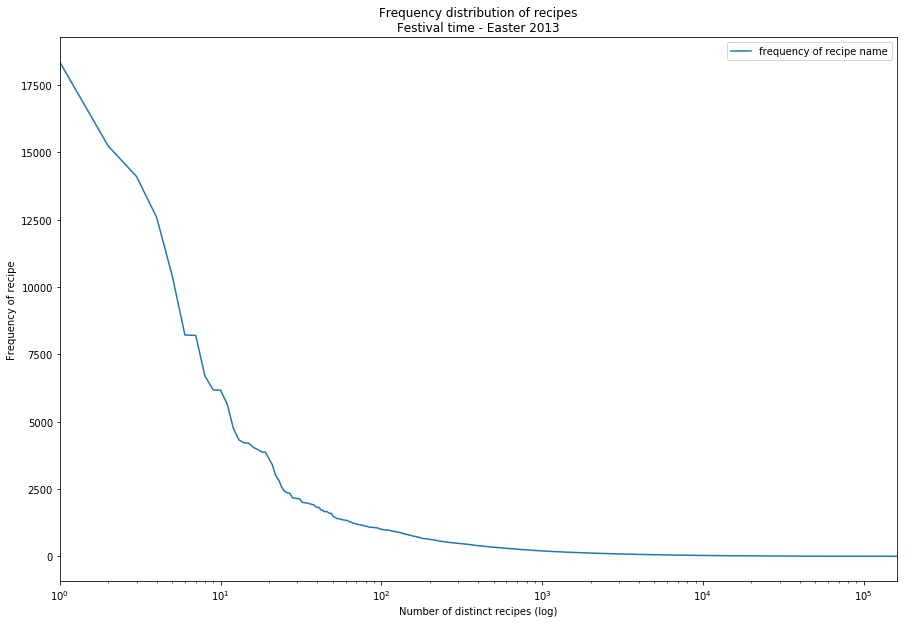

In [20]:
plot_tf_by_df(df_f, "Frequency distribution of recipes \nNon-festival time - Feb 2014", 15, 10, "tf-non-festival-feb.jpg")
plot_tf_by_df(df_n, "Frequency distribution of recipes \nNon-festival time - Nov 2013", 15, 10, "tf-non-festival-nov.jpg")
plot_tf_by_df(df_c, "Frequency distribution of recipes\nFestival time - Christmas 2013 ", 15, 10, "tf-festival-christmas.jpg")
plot_tf_by_df(df_e, "Frequency distribution of recipes\nFestival time - Easter 2013", 15, 10, "tf-festival-easter.jpg")


# Term Frequency Matrix For Regions
**tf** is based on count of recipes as per regions

In [21]:
# function that calculates tf by region
def create_tf_by_region(df):    
    #extract regions from dataset
    regions = df['country_region'].tolist()

    #create a list of distinct regions, alphabetic order
    regions = sorted(set(regions))

    #create a list of distict recipe names, alphabetic order
    all_recipes = df['recipe_name'].tolist()
    all_recipes = sorted(set(all_recipes))


    #create a new dataset for store recipe names, by region
    df_tf = pd.DataFrame(regions, columns=['country_region'])
    df_tf.set_index('country_region', inplace=True)

    #add recipes as columns
    df_tf = df_tf.reindex(columns = all_recipes, fill_value=0)

    #fill the tf_Matrix
    for n in range ( len(df) ):
        df_tf.loc[ df.loc[n,'country_region'], df.loc[n,'recipe_name'] ] += 1
    
    return df_tf

# Loading the tf matrix for four data sets(Festival and Non Festival)

In [22]:

#create term frequency by region, given distinct dataframes
tf_f = create_tf_by_region(df_f)
tf_n = create_tf_by_region(df_n)
tf_c = create_tf_by_region(df_c)
tf_e = create_tf_by_region(df_e)


In [23]:
# review size of the df (#of regions x number of distinct recipes)
tf_f.shape
tf_n.shape
tf_c.shape
tf_e.shape

(16, 169625)

(16, 186533)

(16, 172100)

(16, 160801)

# Calculate the Cosine Similarity on entire data set
Cosine Similarity calculation based on all recipes for **16 Federal states** 

In [25]:
# calculate cosine similarity matrix, for each dataframe (by region)

sim_m_f = np.around(cosine_similarity(tf_f, tf_f), decimals=4)
sim_m_n = np.around(cosine_similarity(tf_n, tf_n), decimals=4)
sim_m_c = np.around(cosine_similarity(tf_c, tf_c), decimals=4)
sim_m_e = np.around(cosine_similarity(tf_e, tf_e), decimals=4)


# Heat_plot Function:

This function will create the heat plot matrix based on cosine similarity by regions. 


In [26]:
def heat_plot(matrix, label, title, size, file_name_to_export):

    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.imshow(matrix,cmap = 'RdYlGn', origin='lower', interpolation='nearest', vmin=0, vmax=1)
    
    # Show ticks
    ax.set_xticks(np.arange(len(label)))
    ax.set_yticks(np.arange(len(label)))

    # Label ticks
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)
        
    # Rotate and aling the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Read the data and create text for each square
    for i in range(len(label)):
        for j in range(len(label)):        
            text = ax.text(j, i, np.around(matrix[i, j], decimals=2), ha="center", va="center", color="k")

    ax.set_title(title+"\n")

    fig.tight_layout()
    plt.show()
    
    fig.savefig(file_name_to_export, bbox_inches='tight')
    
    return

In [27]:
# This is states declartion for graph and future use
states = ['1-BW','2-BY','3-HB','4-HH','5-HE','6-NI','7-NW','8-RP','9-SL','10-SH','11-BB','12-MV','13-SN','14-ST','15-TH','16-BE']

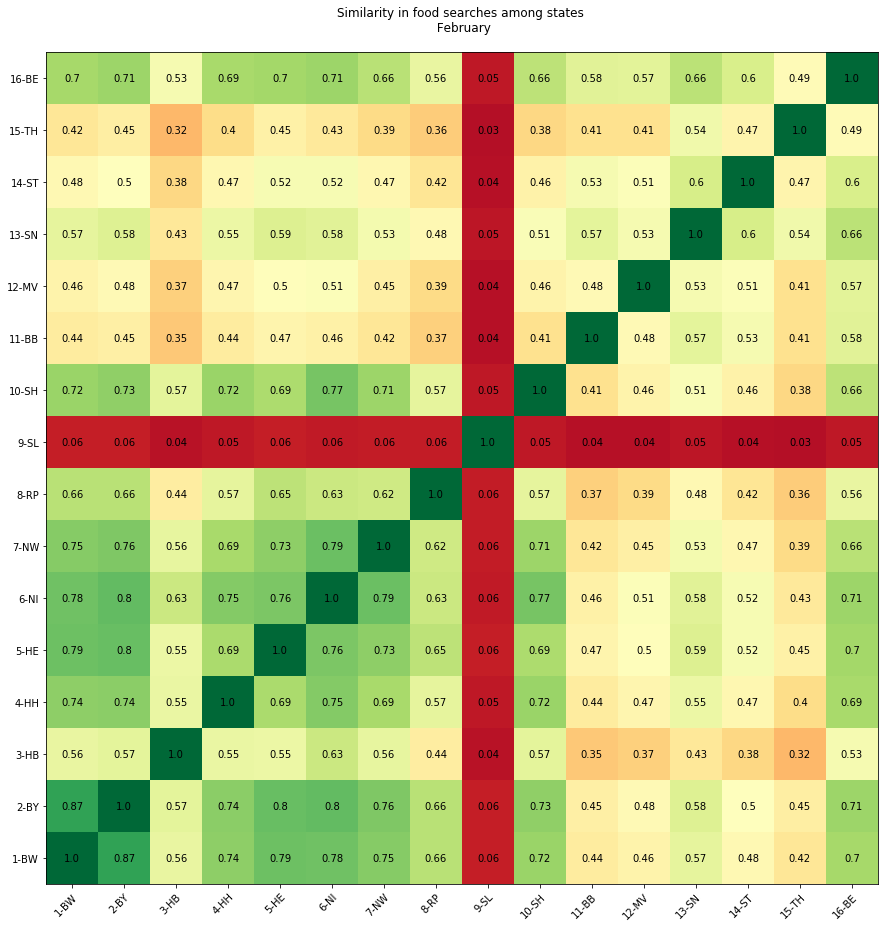

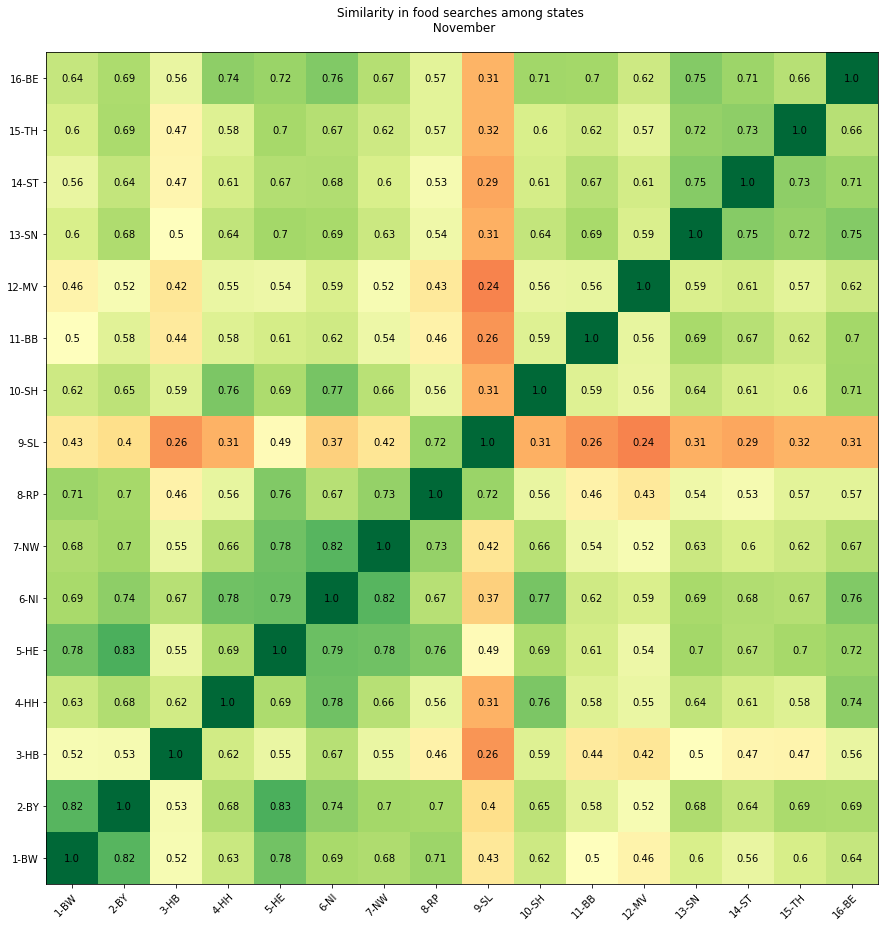

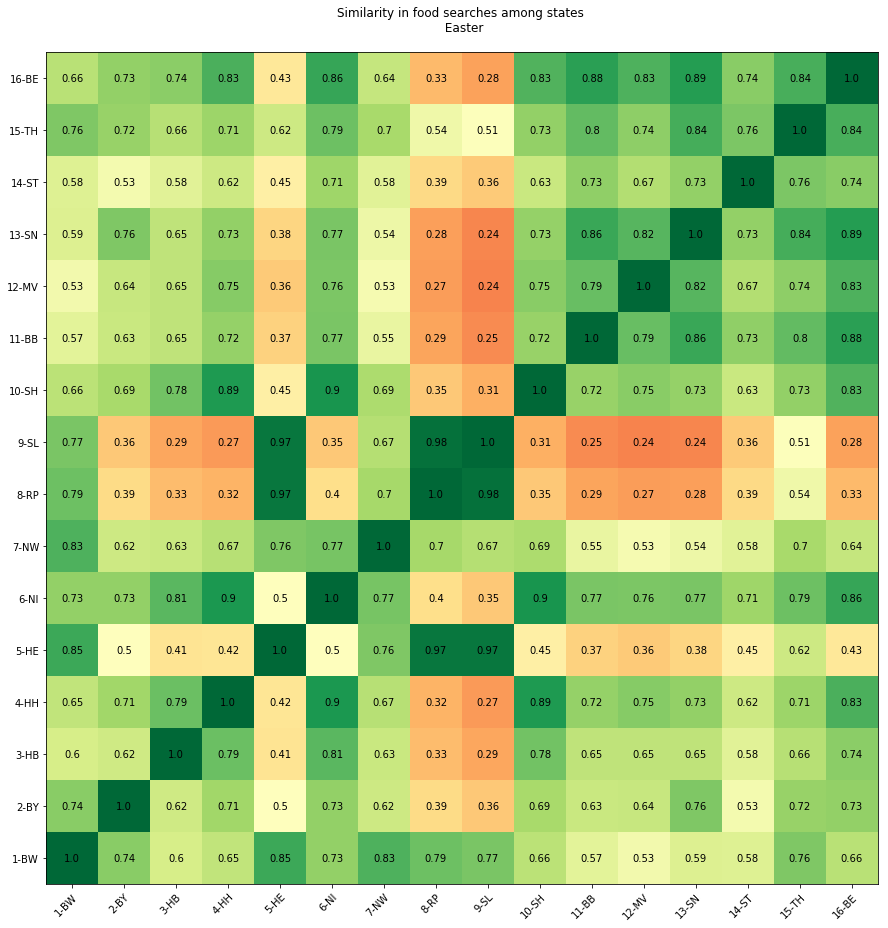

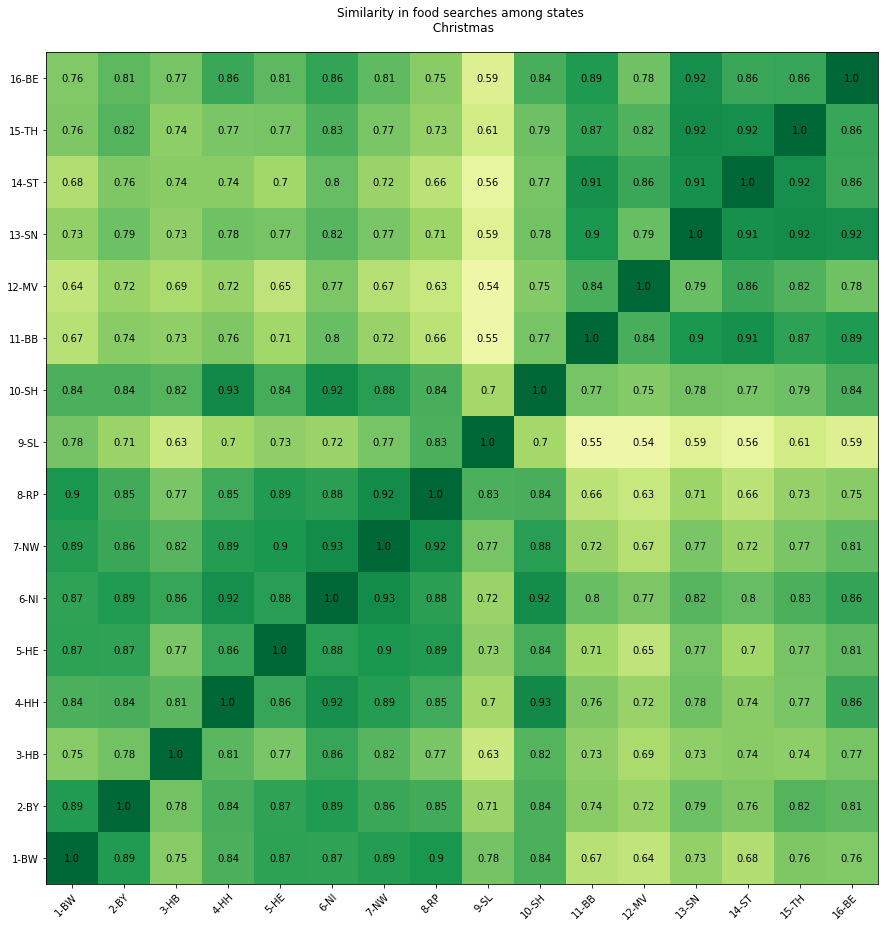

In [29]:
heat_plot(sim_m_f, states, 'Similarity in food searches among states \n February', 13, "output/sim_february.jpg")
heat_plot(sim_m_n, states, "Similarity in food searches among states \n November", 13, "output/sim_november.jpg")
heat_plot(sim_m_e, states, "Similarity in food searches among states \n Easter", 13, "output/sim_easter.jpg")
heat_plot(sim_m_c, states, "Similarity in food searches among states \n Christmas", 13, "output/sim_christmas.jpg")

# Maximum similarity between regions:
This function is used to calculate the maximum similarity on each states/regions

In [30]:
# function to calculate the Maximum similarity between regions, given a dataframe
def df_max_sim_between_regions(sim_matrix, states):
    # data frame for maximum similarity 
    df_High = pd.DataFrame(columns=['Region_Similarity','Regions_name'])
    
    for (index1,element1) in enumerate(sim_matrix):
        max_value=0
        max_index=0
        for (index2,element2) in enumerate(element1):
            
            # removing the same index we dont want that value, max_value  will get 2nd element value
            if (index1 != index2) and max_value < element2 :
                max_value=element2
                max_index=index2
        
        #print(max_value,states[index1],states[max_index])
        df_High=df_High.append({'Region_Similarity':max_value,'Regions_name':states[index1]+'-'+states[max_index] }, ignore_index=True)
    
    df_High.sort_values(by=['Region_Similarity'],inplace=True,ascending=False)
        
    return df_High



# Trend Analysis:
This function will identify the trend analysis based on cosine similarity to region. 

In [31]:
# function to calculate the trend analysis of regions based on cosine similarity
def df_sim_between_regions(sim_matrix, states):
    
    df_High = pd.DataFrame(columns=['Region_Similarity','Regions_name'])
    old_value=[]    
    for (index1,element1) in enumerate(sim_matrix):
        max_value=0
        max_index=0
         
        for (index2,element2) in enumerate(element1):
            
            # removing the same index since we dont want that value
            if (index1 != index2) and element2 not in old_value : 
                max_value=element2
                max_index=index2
                # to avoid repeating values in data frame
                old_value.append(max_value)
                df_High=df_High.append({'Region_Similarity':max_value,'Regions_name':states[index1]+'-'+states[max_index] }, ignore_index=True)       
              
    
    df_High.sort_values(by=['Region_Similarity'],inplace=True,ascending=False)
        
    return df_High

# Plotting  Maximum Similarity and Trend Analysis 
This function will plot both maximum similarity between regions and trend analysis on regions based on recipes

In [32]:
def plot_sim_regions(df, title, filename, size1, size2):
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (size1,size2)
    
    #plt.rcParams['figure.figsize'] = (15, 8)
    #plt.style.use('dark_background')
    
    Region_name = df['Regions_name']
    High_similarity=df['Region_Similarity']
    
    
    plt.plot(Region_name, High_similarity, '-o') 
    plt.title(title, fontsize = 20,weight='bold')
    plt.xlabel('Regions', fontsize=15, weight='bold') 
    plt.ylabel('Cosine similarity value',fontsize=15,weight='bold') 
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10)
    plt.xticks(rotation=90)
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.ylim(0, 1)

    #plt.grid()
    plt.show()
    fig.savefig(filename, bbox_inches='tight')
    return



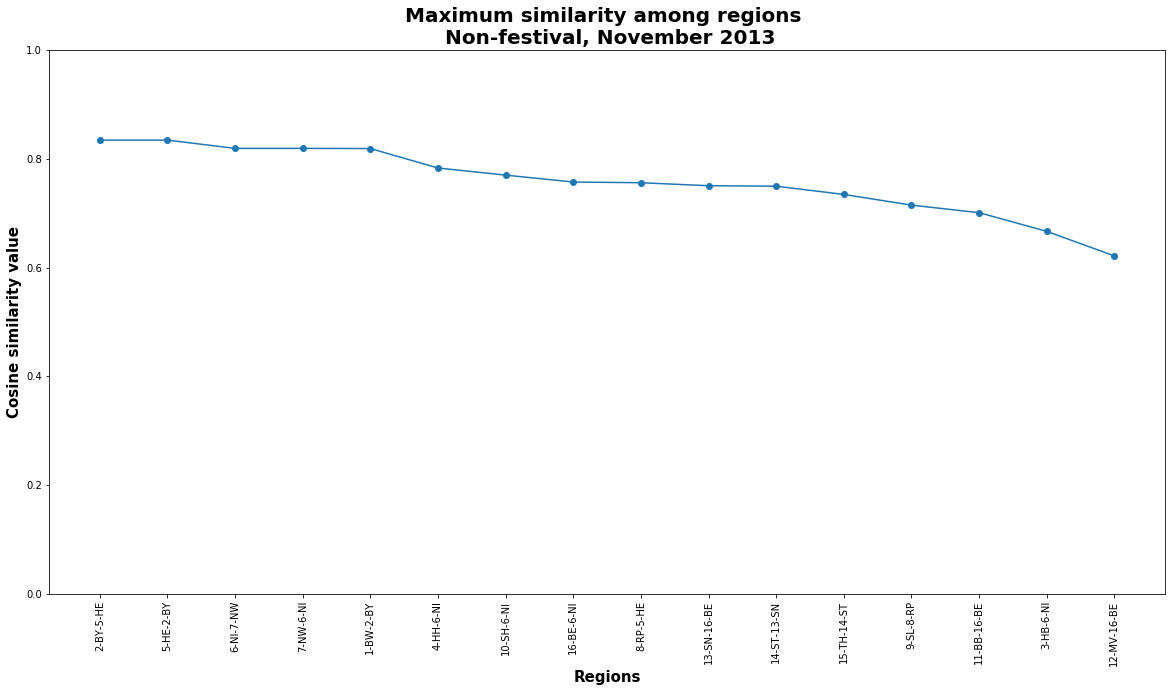

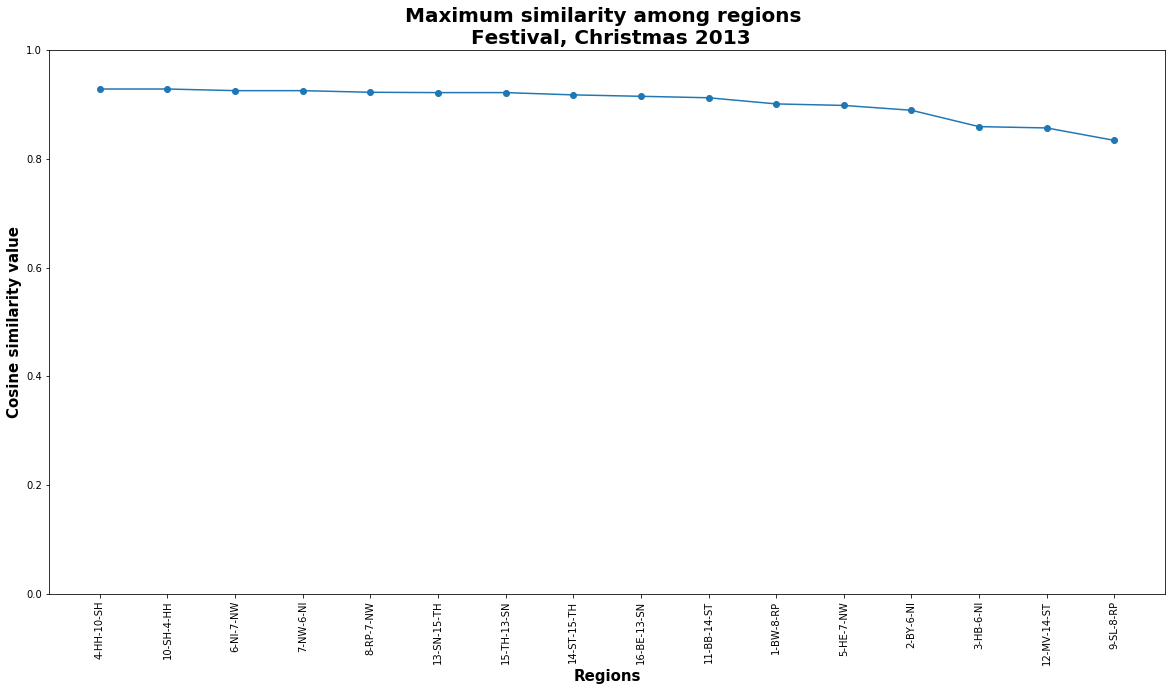

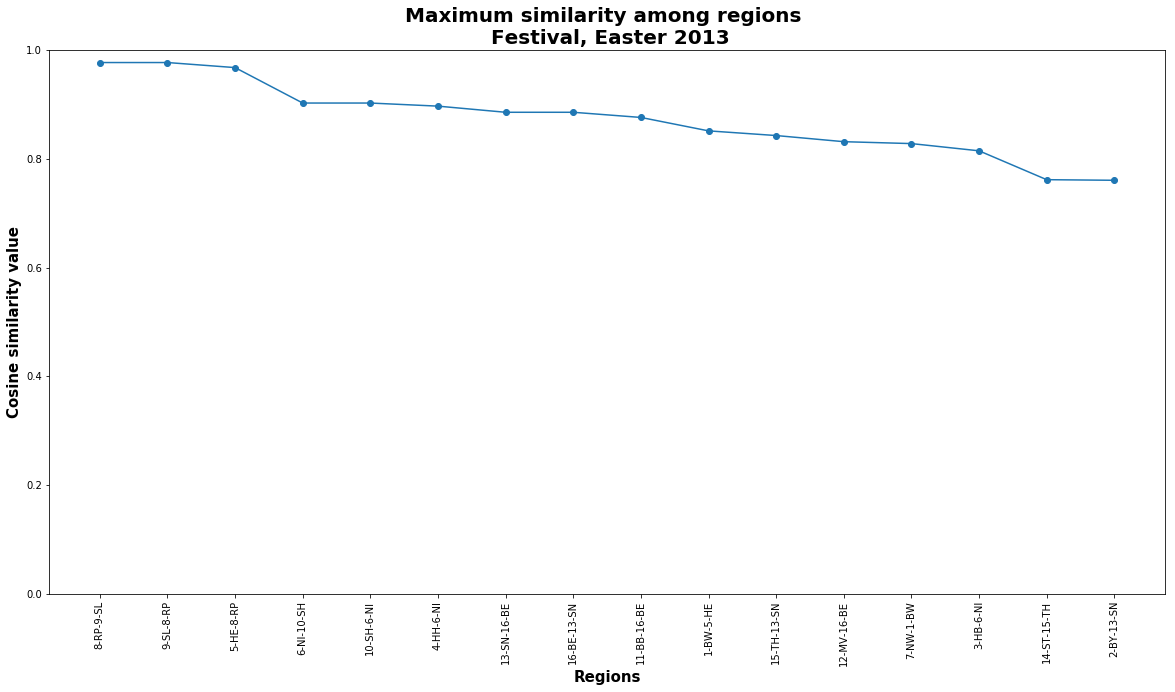

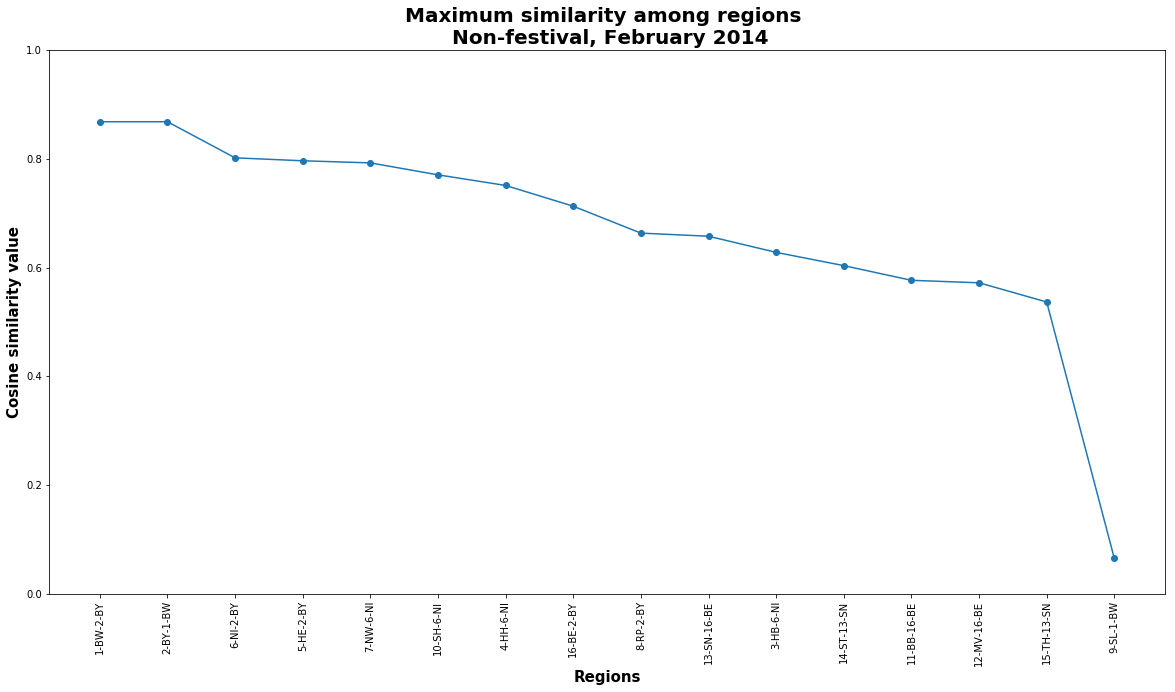

In [34]:
# plot the maximum similarity between regions
plot_sim_regions(df_max_sim_between_regions(sim_m_n, states), "Maximum similarity among regions \n Non-festival, November 2013", "max_sim_November.jpg", 20,10)
plot_sim_regions(df_max_sim_between_regions(sim_m_c, states), "Maximum similarity among regions \n Festival, Christmas 2013", "max_sim_christmas.jpg", 20,10)
plot_sim_regions(df_max_sim_between_regions(sim_m_e, states), "Maximum similarity among regions \n Festival, Easter 2013", "max_sim_easter.jpg", 20,10)
plot_sim_regions(df_max_sim_between_regions(sim_m_f, states), "Maximum similarity among regions \n Non-festival, February 2014", "max_sim_february.jpg", 20,10)

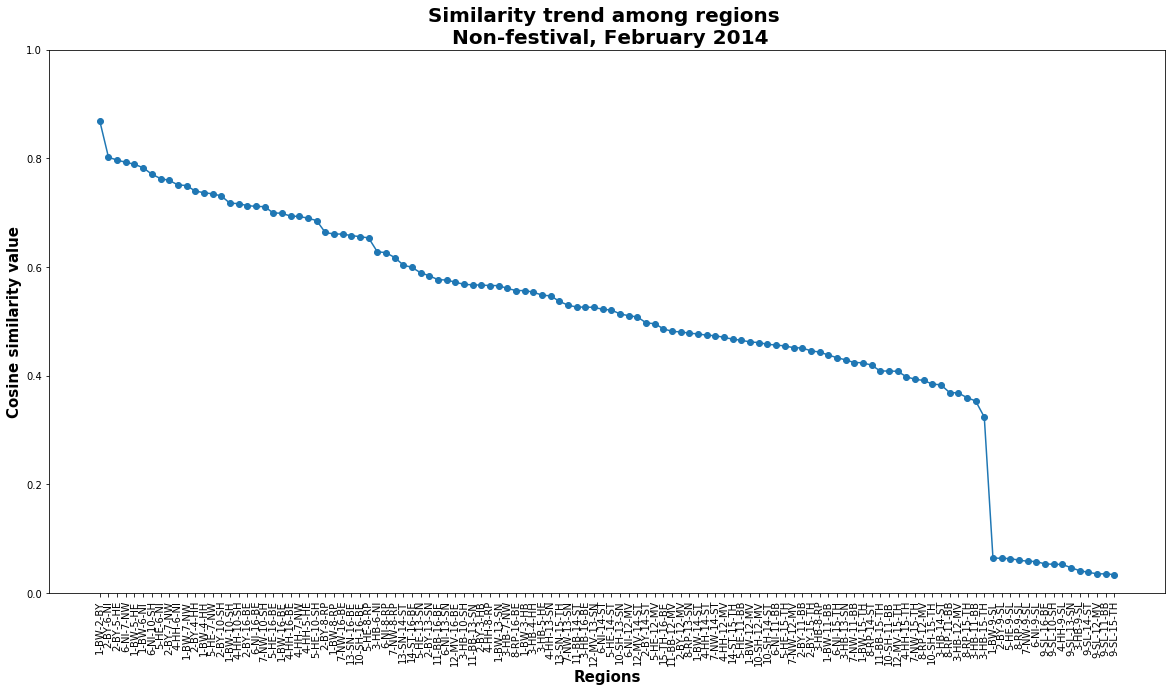

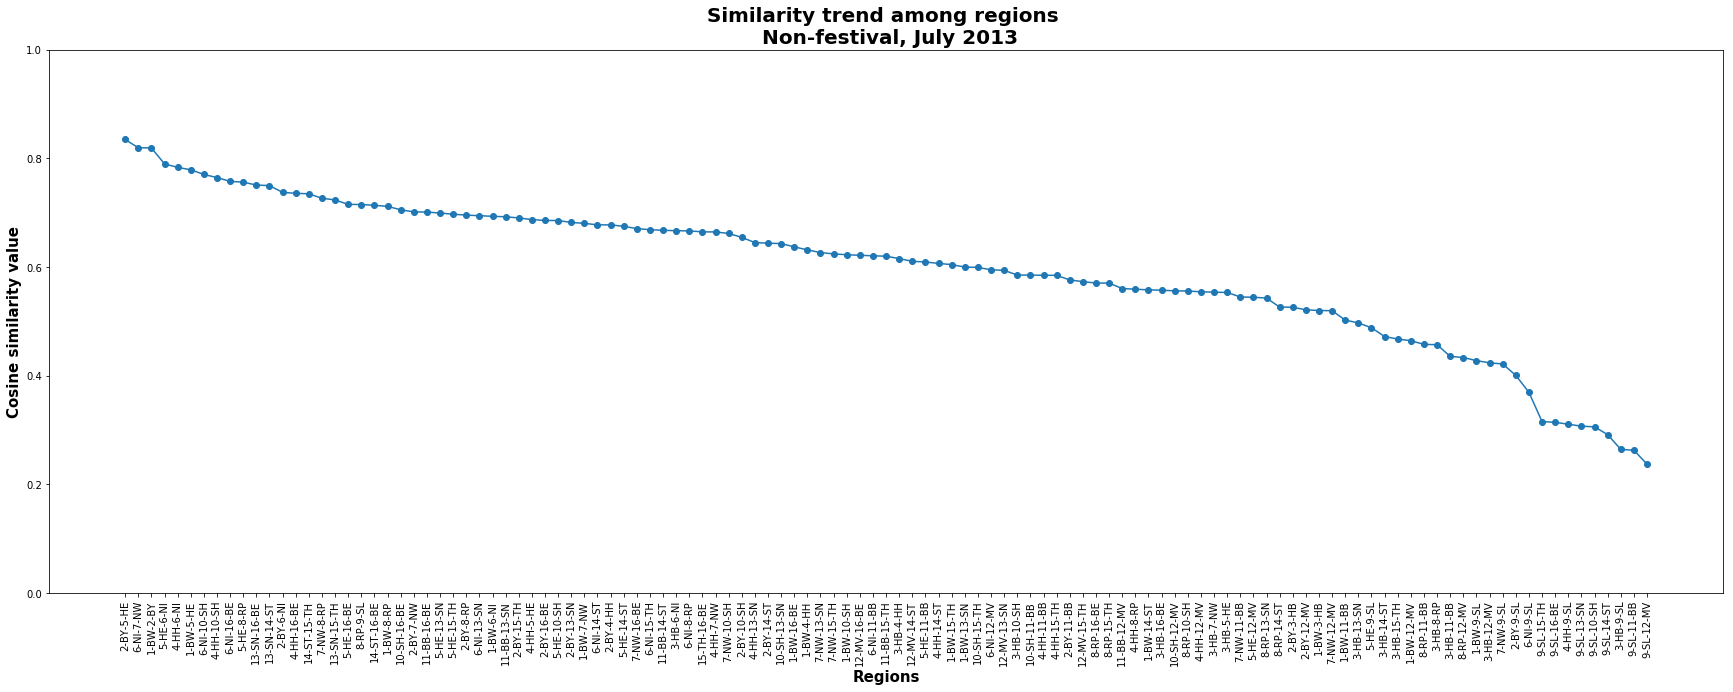

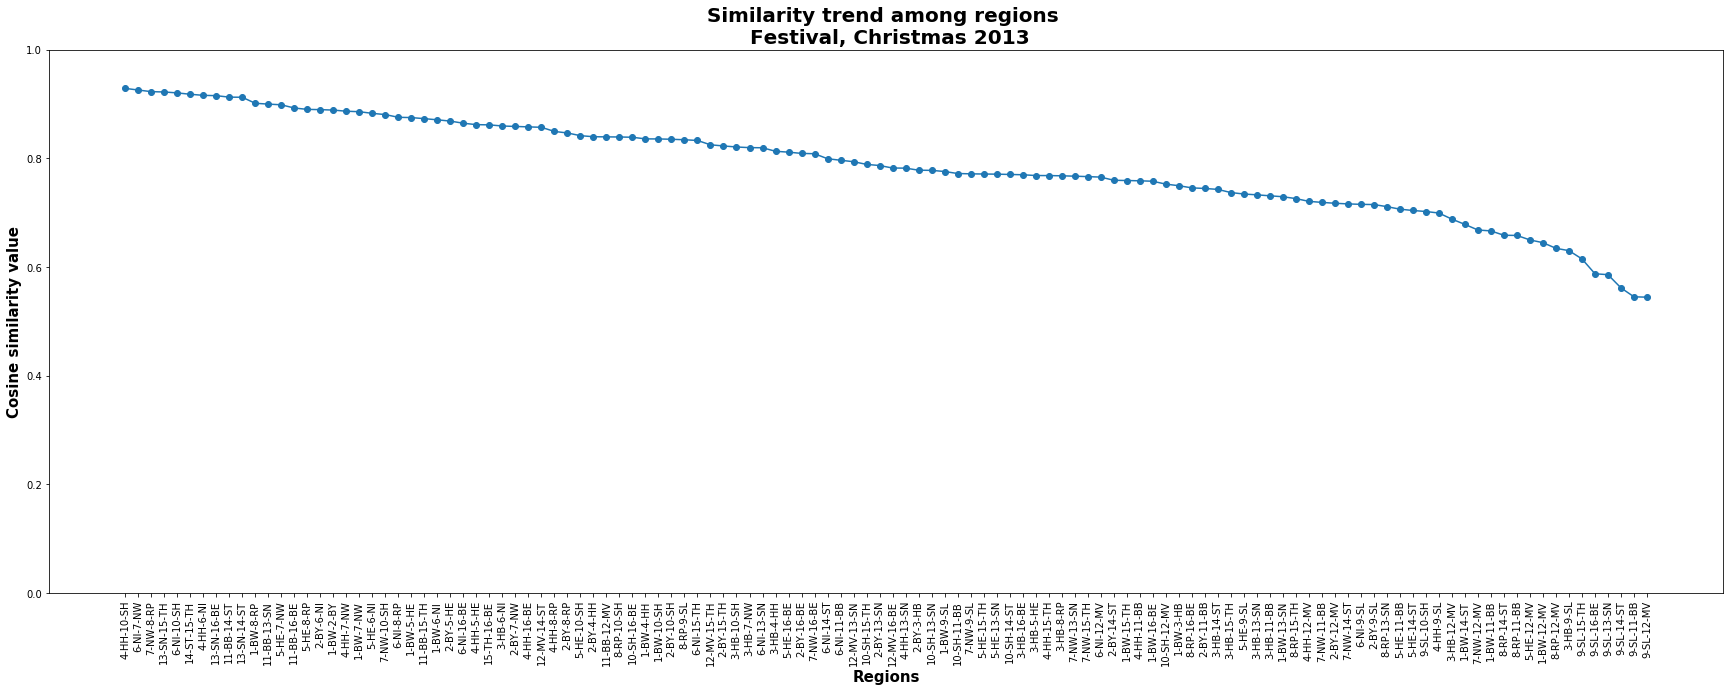

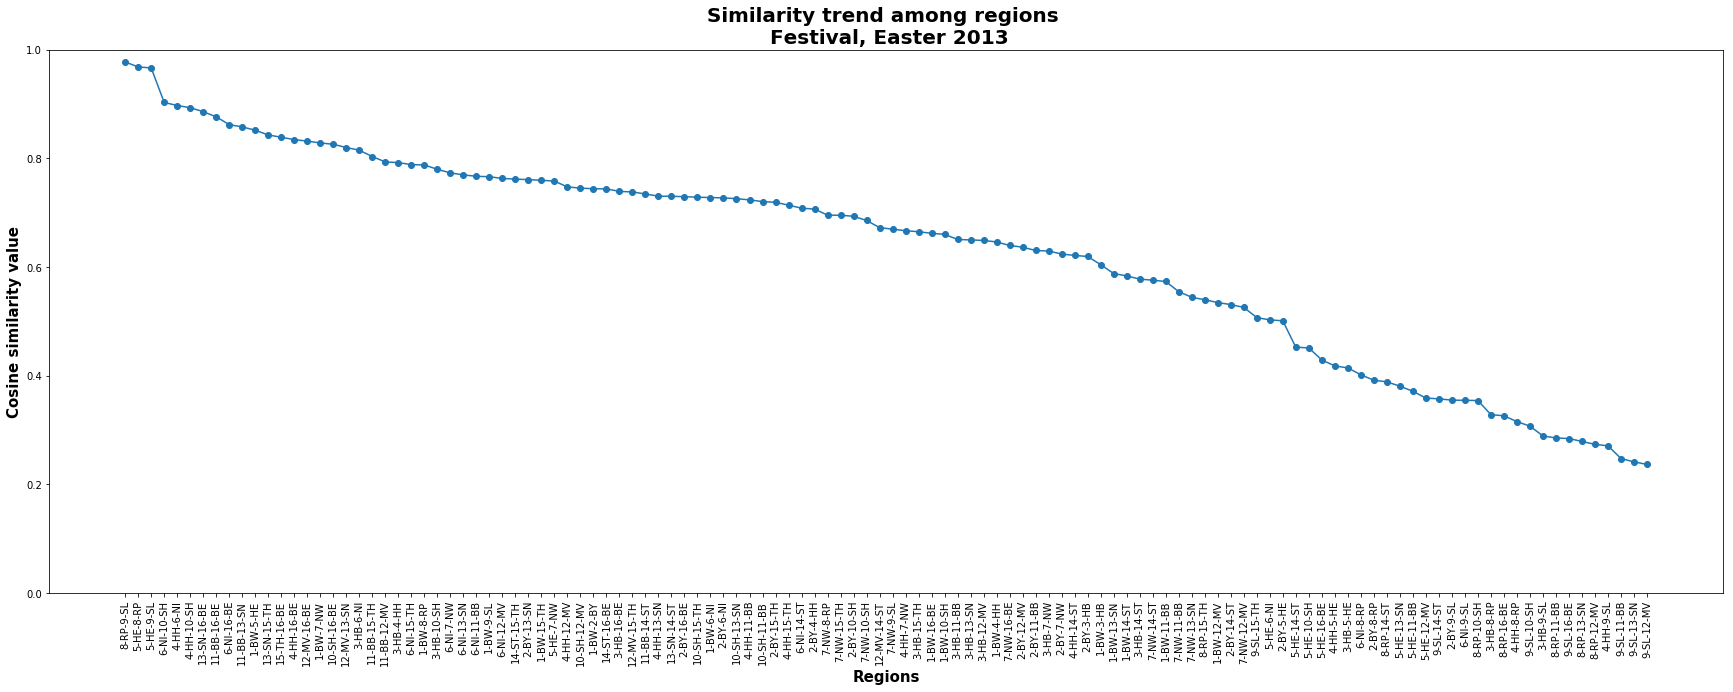

In [35]:
# plot the trend analysis on regions 
plot_sim_regions(df_sim_between_regions(sim_m_f, states), "Similarity trend among regions \n Non-festival, February 2014", "trend_sim_February.jpg", 30,10)
plot_sim_regions(df_sim_between_regions(sim_m_n, states), "Similarity trend among regions \n Non-festival, July 2013", "trend_sim_November.jpg", 30,10)
plot_sim_regions(df_sim_between_regions(sim_m_c, states), "Similarity trend among regions \n Festival, Christmas 2013", "trend_sim_christmas.jpg", 30,10)
plot_sim_regions(df_sim_between_regions(sim_m_e, states), "Similarity trend among regions \n Festival, Easter 2013", "trend_sim_easter.jpg", 30,10)


# Cities Analysis 
From above output regions, we identified the cities from the similar regions and filtering out the cities from existing data frame on both festival and non festival data set

In [36]:
# This function will trim cities from region data frames
def trimm_cities(full_df, cities):
    trimmed_df = full_df[full_df.city.isin(cities)].copy()
    trimmed_df = trimmed_df.reset_index(drop=True)
    
    return trimmed_df

# Cosine Similarity based on cities


In [37]:
# function that calculates tf by all the cities present on the dataframe and then calculates and returns a
# cosine similarity matrix
def create_cos_sim_by_cities(full_df, df):
    #extract cities from dataset
    cities = df['city'].tolist()

    #create a list of distinct cities, alphabetic order
    cities = sorted(set(cities))

    #create a list of distict recipe names, alphabetic order, 
    #taking into account all recipes in the dataframe
    all_recipes = full_df['recipe_name'].tolist()
    all_recipes = sorted(set(all_recipes))

    #create a new dataset for store recipe names, by cities
    df_tf = pd.DataFrame(cities, columns=['city'])
    df_tf.set_index('city', inplace=True)

    #add recipes as columns
    df_tf = df_tf.reindex(columns = all_recipes, fill_value=0)

    #fill the tf_Matrix
    for n in range ( len(df) ):
        df_tf.loc[ df.loc[n,'city'], df.loc[n,'recipe_name'] ] += 1
    
    return np.around(cosine_similarity(df_tf, df_tf), decimals=4)

In [38]:
# This is few selected cities from similar regions Hessen,Norrhein-westfalen,Saarland and Baden-Wuttemburg
cities1 = ['Köln','Frankfurt_Am_Main', 'Stuttgart', 'Saarbrücken']
# Cosine Simialrity by cities for Region Set 1 
c1_f = create_cos_sim_by_cities(df_f, trimm_cities(df_f, cities1))
c1_c = create_cos_sim_by_cities(df_c, trimm_cities(df_c, cities1))
c1_e = create_cos_sim_by_cities(df_e, trimm_cities(df_e, cities1))
c1_n = create_cos_sim_by_cities(df_n, trimm_cities(df_n, cities1))
# This is few selected cities from similar regions Hamburg,Nordrhein-westfalen,Nidersachesen 
cities2 = ['Hamburg', 'Hanover', 'Köln', 'Düsseldorf']
# Cosine Simialrity by cities for Region Set2
c2_f = create_cos_sim_by_cities(df_f, trimm_cities(df_f, cities2))
c2_c = create_cos_sim_by_cities(df_c, trimm_cities(df_c, cities2))
c2_e = create_cos_sim_by_cities(df_e, trimm_cities(df_e, cities2))
c2_n = create_cos_sim_by_cities(df_n, trimm_cities(df_n, cities2))
# This is few selected cities from similar regions Saxony Anhalt, Thuringia and Sachsen
cities3 = ['Halle', 'Erfurt', 'Dresden', 'Leipzig']
# Cosine Simialrity by cities for Region Set3
c3_f = create_cos_sim_by_cities(df_f, trimm_cities(df_f, cities3))
c3_c = create_cos_sim_by_cities(df_c, trimm_cities(df_c, cities3))
c3_e = create_cos_sim_by_cities(df_e, trimm_cities(df_e, cities3))
c3_n = create_cos_sim_by_cities(df_n, trimm_cities(df_n, cities3))



# Trend Analysis on Cities
This function will do the trend analysis on city pairs by sorted distance in ascending order

In [39]:
# Function to prepare a dataframe, with city pairs order by the distance between the listed cities
# Parameters:
# Cities - recieves a list of cities to be compared
# sim_matrix - similarity matrix between cities listed
# city_distance_file -  excel file with the distance in kms between given cities

def df_sim_trend_between_cities(sim_matrix, Cities, city_distance_file):
    
    df_city_distance = pd.read_excel(city_distance_file)
    del df_city_distance['City']
    df = pd.DataFrame(columns=['Cities_Similarity','Cities_name','Distance'])
    old_value=[]
    
    #takes first array in the similarity matrix
    for (index1,element1) in enumerate(sim_matrix):
        max_value=0
        max_index=0
        distance=0
        
        #take the first element from the first array
        for (index2,element2) in enumerate(element1):
            # removing the same index we dont want that value, max_value  will get 2nd element value
            if (index1 != index2) and element2 not in old_value  :
                max_value=element2
                max_index=index2
                old_value.append(element2)
                distance=(df_city_distance.values[index1][index2])
                #print(max_value,Cities[index1],Cities[max_index],distance)
                #save values in dataframe
                df=df.append({'Cities_Similarity':max_value,'Cities_name':Cities[index1]+'-'+Cities[max_index] ,'Distance':distance}, ignore_index=True)
    
    #sort values by distance
    df.sort_values(by=['Distance'],inplace=True ,ascending=True)
    
    return df


In [40]:
# dataframe created for the city wise pair set 1 with incoprated distance information and its odered by distance 
d_sim_c1_n=df_sim_trend_between_cities(c1_n, cities1,'First_Region_similarity_City_distance.xlsx')
d_sim_c1_f=df_sim_trend_between_cities(c1_f, cities1,'First_Region_similarity_City_distance.xlsx')
d_sim_c1_e=df_sim_trend_between_cities(c1_e, cities1,'First_Region_similarity_City_distance.xlsx')
d_sim_c1_c=df_sim_trend_between_cities(c1_c, cities1,'First_Region_similarity_City_distance.xlsx')

# dataframe created for the city wise pair set 2 with incoprated distance information and its odered by distance 
d_sim_c2_n=df_sim_trend_between_cities(c2_n, cities2,'Second_region_sim_city_distance.xlsx')
d_sim_c2_f=df_sim_trend_between_cities(c2_f, cities2,'Second_region_sim_city_distance.xlsx')
d_sim_c2_e=df_sim_trend_between_cities(c2_e, cities2,'Second_region_sim_city_distance.xlsx')
d_sim_c2_c=df_sim_trend_between_cities(c2_c, cities2,'Second_region_sim_city_distance.xlsx')

# dataframe created for the city wise pair set 3 with incoprated distance information and its odered by distance

d_sim_c3_n=df_sim_trend_between_cities(c3_n, cities3,'Third_region_sim_city_distance.xlsx')
d_sim_c3_f=df_sim_trend_between_cities(c3_f, cities3,'Third_region_sim_city_distance.xlsx')
d_sim_c3_e=df_sim_trend_between_cities(c3_e, cities3,'Third_region_sim_city_distance.xlsx')
d_sim_c3_c=df_sim_trend_between_cities(c3_c, cities3,'Third_region_sim_city_distance.xlsx')


# Plot the trend analysis on cities
This function will plot the trend analysis on cities

In [41]:
def plot_trend_sim_city_all_period(df_n,df_f,df_e,df_c, title, filename, size1, size2):
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (size1,size2)
    df_whole_city_pairs = pd.DataFrame(columns=['Non_festiv_Nov','Non_festiv_Feb','Easter','Chirstmas','Cities_name','Distance'])
    
    #plt.rcParams['figure.figsize'] = (15, 8)
    #plt.style.use('dark_background')
    
    Region_name_n = df_n['Cities_name']
    High_similarity_n=df_n['Cities_Similarity']
    
        
    Region_name_f = df_f['Cities_name']
    High_similarity_f=df_f['Cities_Similarity']
    
        
    Region_name_e = df_e['Cities_name']
    High_similarity_e=df_e['Cities_Similarity']
    
        
    Region_name_c = df_c['Cities_name']
    High_similarity_c=df_c['Cities_Similarity']

    #sns.lineplot(Region_name, High_similarity, color = 'red')

    plt.plot(Region_name_n, High_similarity_n,'-o',label='Non-festival-November') 

    plt.plot(Region_name_f, High_similarity_f,'-o',label='Non-festival-February')

    plt.plot(Region_name_e, High_similarity_e,'-o',label='festival-easter')
    
    plt.plot(Region_name_c, High_similarity_c,'-o',label='festival-chirstmas') 
        
    plt.title(title, fontsize = 20,weight='bold')
    plt.xlabel('City pairs, order by distance',fontsize=15,weight='bold') 
    plt.ylabel('Cosine similarity value',fontsize=15,weight='bold') 
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10)
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.legend()
    #plt.grid()
    plt.show()
    fig.savefig(filename, bbox_inches='tight')
    df_whole_city_pairs["Non_festiv_Nov"]=df_n['Cities_Similarity']
    df_whole_city_pairs["Non_festiv_Feb"]=df_f['Cities_Similarity']
    df_whole_city_pairs["Easter"]=df_e['Cities_Similarity']
    df_whole_city_pairs["Chirstmas"]=df_c['Cities_Similarity']
    df_whole_city_pairs["Cities_name"]=df_n['Cities_name']
    df_whole_city_pairs["Distance"]=df_n['Distance']
    df_whole_city_pairs.reset_index(drop=True)
    print("Dataframe of Graph")
    print('\n')
    print(df_whole_city_pairs)
    

    return df_whole_city_pairs

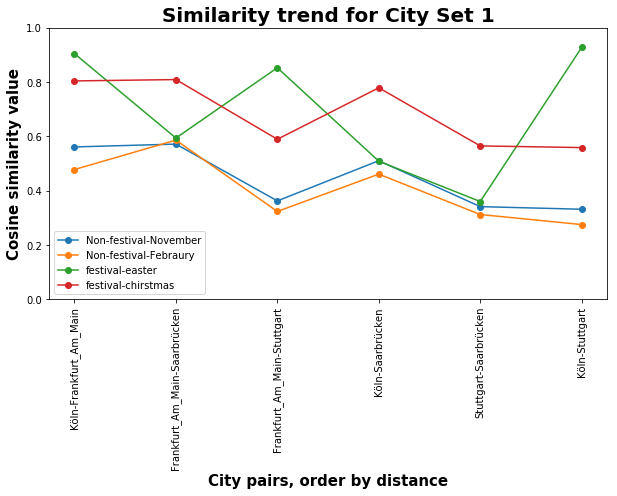

Dataframe of Graph


   Non_festiv_Nov  Non_festiv_Feb  Easter  Chirstmas  \
0          0.5610          0.4779  0.9043     0.8039   
4          0.5715          0.5861  0.5937     0.8089   
3          0.3625          0.3236  0.8523     0.5893   
2          0.5104          0.4610  0.5085     0.7786   
5          0.3414          0.3124  0.3602     0.5648   
1          0.3318          0.2754  0.9273     0.5587   

                     Cities_name  Distance  
0         Köln-Frankfurt_Am_Main     192.1  
4  Frankfurt_Am_Main-Saarbrücken     198.0  
3    Frankfurt_Am_Main-Stuttgart     203.6  
2               Köln-Saarbrücken     258.8  
5          Stuttgart-Saarbrücken     269.0  
1                 Köln-Stuttgart     378.6  


In [44]:
#Plotting the Region 1 set of cities 
df_city_set1=plot_trend_sim_city_all_period(d_sim_c1_n,d_sim_c1_f,d_sim_c1_e,d_sim_c1_c, "Similarity trend for City Set 1", "sim_trend_by_cities_set1.jpg", 10,5)

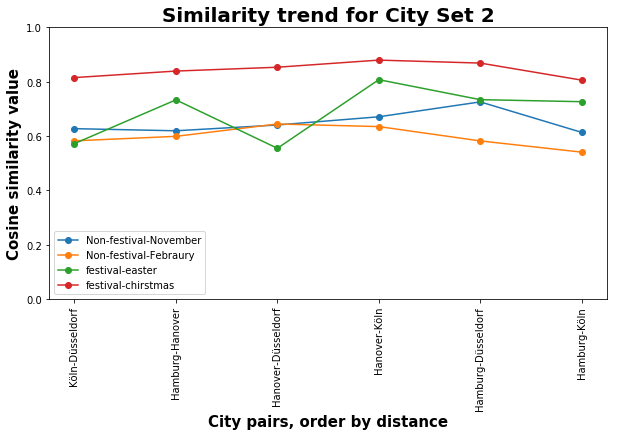

Dataframe of Graph


   Non_festiv_Nov  Non_festiv_Feb  Easter  Chirstmas         Cities_name  \
5          0.6269          0.5821  0.5719     0.8148     Köln-Düsseldorf   
0          0.6191          0.5986  0.7329     0.8388     Hamburg-Hanover   
4          0.6404          0.6441  0.5547     0.8529  Hanover-Düsseldorf   
3          0.6706          0.6345  0.8071     0.8791        Hanover-Köln   
2          0.7254          0.5818  0.7336     0.8682  Hamburg-Düsseldorf   
1          0.6132          0.5405  0.7261     0.8054        Hamburg-Köln   

   Distance  
5      44.5  
0     159.0  
4     291.8  
3     294.3  
2     406.8  
1     424.8  


In [45]:
#Plotting for city set 2

df_city_set2=plot_trend_sim_city_all_period(d_sim_c2_n,d_sim_c2_f,d_sim_c2_e,d_sim_c2_c,"Similarity trend for City Set 2", "sim_trend_by_cities_set2.jpg", 10,5)


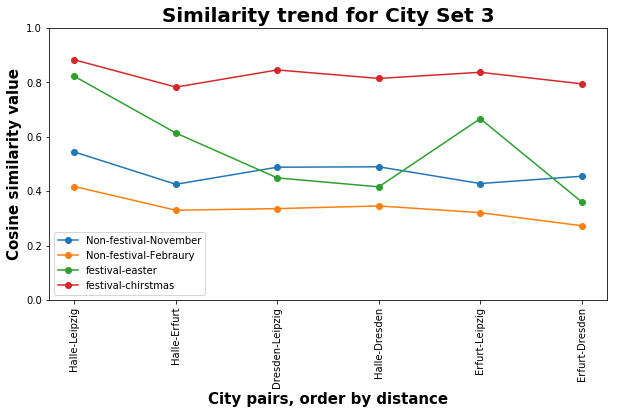

Dataframe of Graph


   Non_festiv_Nov  Non_festiv_Feb  Easter  Chirstmas      Cities_name  \
2          0.5443          0.4173  0.8226     0.8834    Halle-Leipzig   
0          0.4254          0.3299  0.6139     0.7830     Halle-Erfurt   
5          0.4883          0.3360  0.4489     0.8461  Dresden-Leipzig   
1          0.4898          0.3458  0.4161     0.8149    Halle-Dresden   
4          0.4282          0.3210  0.6670     0.8375   Erfurt-Leipzig   
3          0.4551          0.2729  0.3608     0.7951   Erfurt-Dresden   

   Distance  
2      43.0  
0     118.1  
5     121.0  
1     145.6  
4     146.8  
3     216.0  


In [46]:
#plotting for city set 2
df_city_set3=plot_trend_sim_city_all_period( d_sim_c3_n,d_sim_c3_f,d_sim_c3_e,d_sim_c3_c,"Similarity trend for City Set 3", "sim_trend_by_cities_set3.jpg", 10,5)


# Correlation Analysis
This function will do the correlation analysis between city similariy and distance for all festival and non festival days
This output will helps to identify that, distance is really impacting the similarity or not. 

In [47]:
 def Correlation_btw_Sim_dis(df):
        
        Correlation=[]
        Correlation.append(df['Non_festiv_Nov'].corr(df['Distance']))
        Correlation.append(df['Non_festiv_Feb'].corr(df['Distance']))
        Correlation.append(df['Easter'].corr(df['Distance']))
        Correlation.append(df['Chirstmas'].corr(df['Distance']))
        
        return Correlation

# Out put from Correlation function:
From output we can identify that which city sets on which period have highest and lowest negtive correlation

In [48]:

Dataframe_corr = pd.DataFrame(columns=['Correlation_City_set1','Correlation_City_set2','Correlation_City_set3'],index=['Non_festiv_Nov','Non_festiv_Feb','Easter','Chirstmas'])

Correlation_City_set1=Correlation_btw_Sim_dis(df_city_set1)
Correlation_City_set2=Correlation_btw_Sim_dis(df_city_set2)
Correlation_City_set3=Correlation_btw_Sim_dis(df_city_set3)

Dataframe_corr["Correlation_City_set1"]=Correlation_City_set1
Dataframe_corr["Correlation_City_set2"]=Correlation_City_set2
Dataframe_corr["Correlation_City_set3"]=Correlation_City_set3

Dataframe_corr

,Correlation_City_set1,Correlation_City_set2,Correlation_City_set3
Non_festiv_Nov,-0.632698,0.435798,-0.616307
Non_festiv_Feb,-0.647162,-0.204599,-0.956797
Easter,0.092030,0.451341,-0.808931
Chirstmas,-0.600657,0.259743,-0.709672
